In [1]:
# This file makes ET averages for the time intervals. 
# Note that randomness would need to be inserted before this step in order to bootstrap. 

# Anna Boser November 5, 2021

from pyprojroot import here
import rasterio
from rasterio.plot import show
import datetime
import numpy as np
import pandas as pd
import csv
import time
from osgeo import gdal#, gdalconst
import matplotlib.pyplot as plt
import math
# from os import listdir

In [2]:
# first figure out for each interval which substacks to read in 
# get dates
date_list = pd.read_csv(here("./data/intermediate/ECOSTRESS/dates.csv"))['x'].tolist()
date_list = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in date_list]
date_starts = [datetime.date(day = 15, month = m, year = y) for y in range(2019,2021) for m in [1,3,5,7,9,11]]
del date_starts[1]

# index of image on or nearest after start date
start_index = [date_list.index(min([i for i in date_list if i >= date_start], key=lambda x:x-date_start)) for date_start in date_starts] 

# index of image on or nearest previous to start date + 61 days (this is for a non-inclusive index range so this date will be the first not to be included in a subset)
end_index = [date_list.index(min([i for i in date_list if i <= date_start + datetime.timedelta(days=61)], key=lambda x:date_start+datetime.timedelta(days=61)-x)) + 1 for date_start in date_starts] 


In [3]:
print(start_index)
print(end_index)

[1, 80, 194, 301, 385, 425, 485, 579, 692, 799, 894]
[80, 195, 301, 385, 423, 485, 579, 689, 798, 892, 948]


In [4]:
# get metadata
img = rasterio.open(str(here("./data/intermediate/CA_grid.tif")))
metadata = img.profile

In [5]:
i = 0

In [6]:
    start = start_index[i]
    end = end_index[i]
    start_stack = math.floor(start/50) + 1 # plus once since the way I stored it is not zero indexed
    end_stack = math.floor((end-1)/50) + 1 #end-1 since end is non-inclusive
    print("Start_stack {}".format(start_stack))
    print("End_stack {}".format(end_stack))
    
    start = start - 50*(start_stack-1)
    end = end - 50*(start_stack-1)
    print(start)
    print(end)
    
    weights = []
    means = []

Start_stack 1
End_stack 2
1
80


In [7]:
j = 1

In [38]:
        stack = gdal.Open(str(here("./data/intermediate/ECOSTRESS/ETinst_OGunits_{}.tif".format(j))))
        a = stack.ReadAsArray()
        del stack
        a[a < -20] = np.NaN
        print(a.shape)
        
        starter = start
        ender = min(end, a.shape[0]) # plus one to make it non-inclusive
        print(starter)
        print(ender)
        
        weights = weights + [ender - starter]
        print(weights)
        
        means = means + [np.nanmean(a[starter:ender], axis = 0)] # remember ender is not included
        print("successfully took mean of current stack")
        
        start = start - 50
        end = end - 50

(50, 15017, 16289)
1
50
[49]
successfully took mean of current stack


<ipython-input-38-2880f971815e>:15: RuntimeWarning: Mean of empty slice
  means = means + [np.nanmean(a[starter:ender], axis = 0)] # remember ender is not included


In [39]:
        del a

In [48]:
j = 2

In [44]:
weights = [weights[0]]
means = [means[0]]

In [46]:
start = 0

In [47]:
end = end -50
end

30

In [49]:
        print("Working on stack {}".format(j))

        # read in the required stacks
        stack = gdal.Open(str(here("./data/intermediate/ECOSTRESS/ETinst_OGunits_{}.tif".format(j))))
        a = stack.ReadAsArray()
        del stack
        a[a < -20] = np.NaN
        print(a.shape)
        
        starter = start
        ender = min(end, a.shape[0]) # plus one to make it non-inclusive
        print(starter)
        print(ender)
        
        weights = weights + [ender - starter]
        print(weights)
        
        means = means + [np.nanmean(a[starter:ender], axis = 0)] # remember ender is not included
        print("successfully took mean of current stack")
        
        start = 0
        end = end - 50
        del a

Working on stack 2
(50, 15017, 16289)
0
30
[49, 30]


<ipython-input-49-7c3a97a064d9>:18: RuntimeWarning: Mean of empty slice
  means = means + [np.nanmean(a[starter:ender], axis = 0)] # remember ender is not included


successfully took mean of current stack


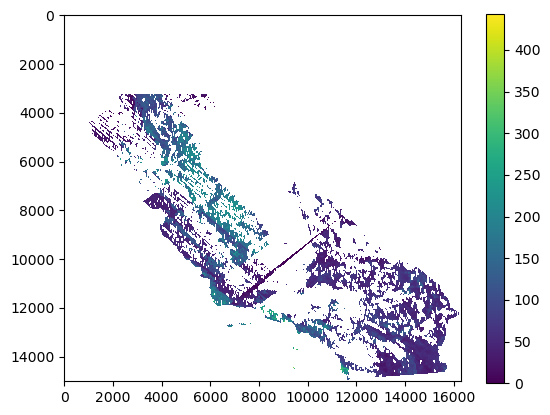

In [50]:
plt.figure()
plt.imshow(means[0])
plt.colorbar()
plt.show()

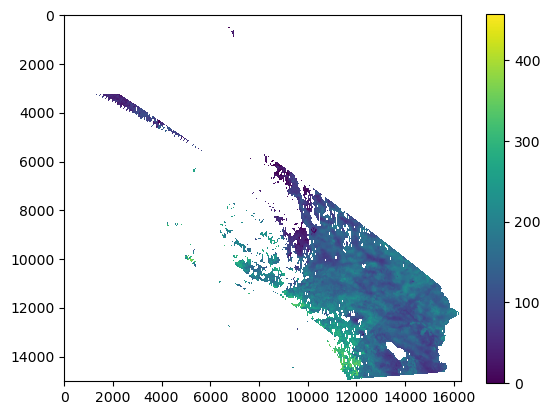

In [51]:
plt.figure()
plt.imshow(means[1])
plt.colorbar()
plt.show()

In [52]:
    meanstack = np.stack(means, axis = 0)
    print(meanstack.shape)
    masked_data = np.ma.masked_array(meanstack, np.isnan(meanstack))
    average = np.ma.average(masked_data, axis=0, weights=weights)
    result = average.filled(np.nan)
    print(result.shape)

(2, 15017, 16289)
(15017, 16289)


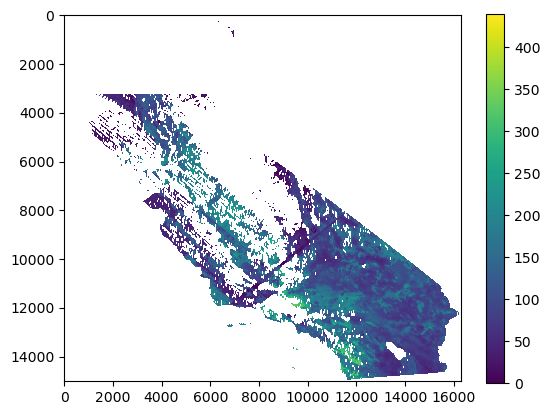

In [53]:
plt.figure()
plt.imshow(result)
plt.colorbar()
plt.show()

In [19]:
    masked_data = np.ma.masked_array(a[starter:ender], np.isnan(a[starter:ender]))
    average = np.ma.average(masked_data, axis=0)
    result = average.filled(np.nan)

/opt/anaconda3/envs/bplayground/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [23]:
np.max(average)

masked

In [9]:
        stack = gdal.Open(str(here("./data/intermediate/ECOSTRESS/ETinst_OGunits_{}.tif".format(1))))
        a = stack.ReadAsArray()

In [10]:
a[a < -20] = np.NaN

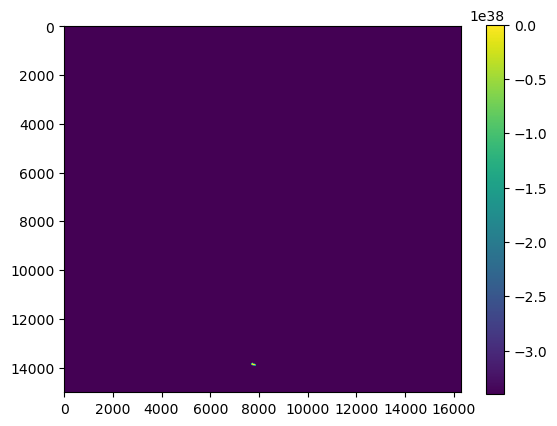

In [60]:
plt.figure()
plt.imshow(a[0,:,:])
plt.colorbar()
plt.show()

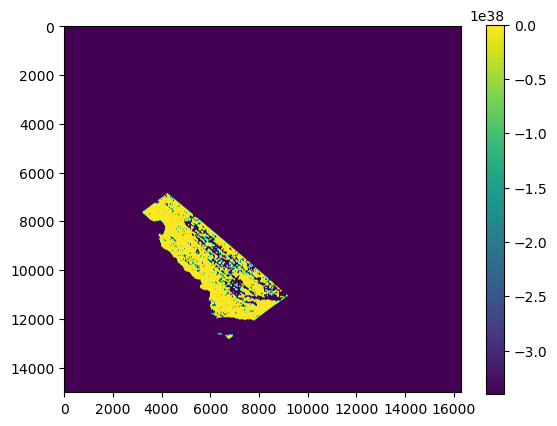

In [61]:
plt.figure()
plt.imshow(a[1,:,:])
plt.colorbar()
plt.show()

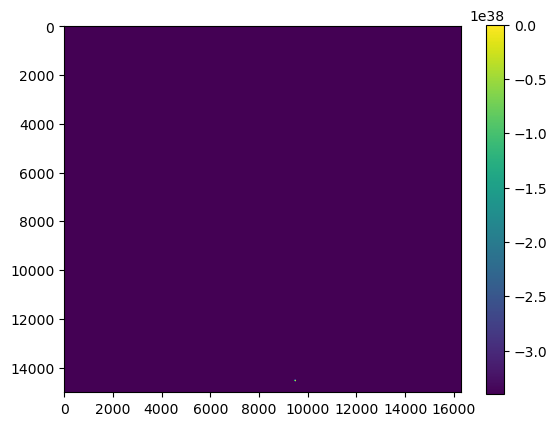

In [62]:
plt.figure()
plt.imshow(a[2,:,:])
plt.colorbar()
plt.show()

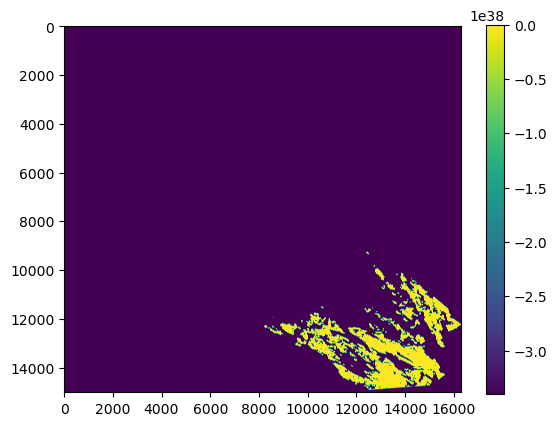

In [16]:
plt.figure()
plt.imshow(a[3,:,:])
plt.colorbar()
plt.show()

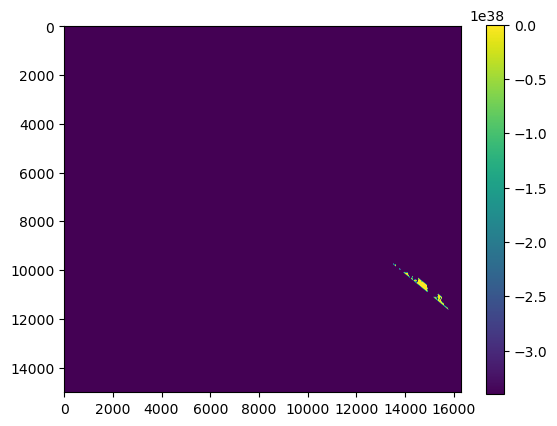

In [63]:
plt.figure()
plt.imshow(a[4,:,:])
plt.colorbar()
plt.show()

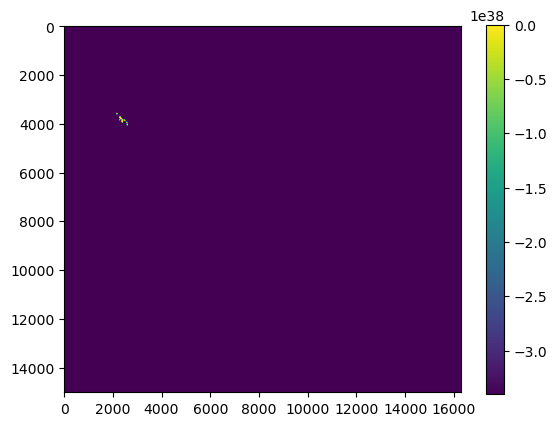

In [64]:
plt.figure()
plt.imshow(a[5,:,:])
plt.colorbar()
plt.show()

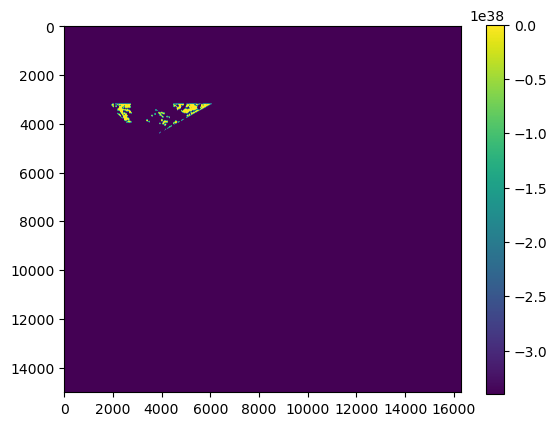

In [65]:
plt.figure()
plt.imshow(a[6,:,:])
plt.colorbar()
plt.show()

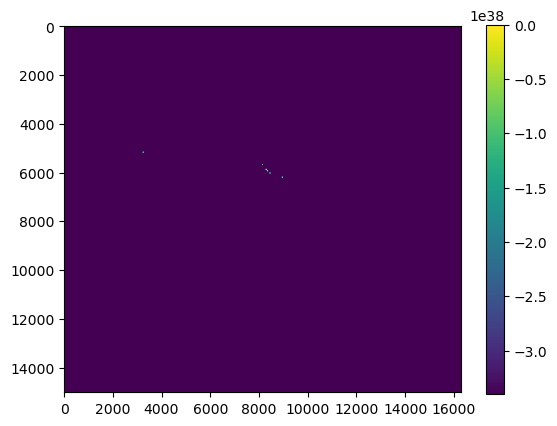

In [66]:
plt.figure()
plt.imshow(a[7,:,:])
plt.colorbar()
plt.show()

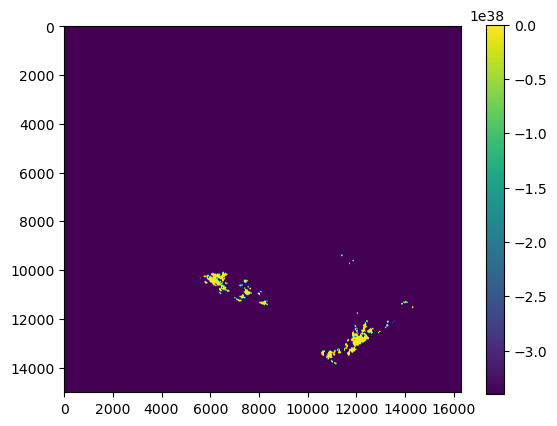

In [67]:
plt.figure()
plt.imshow(a[8,:,:])
plt.colorbar()
plt.show()

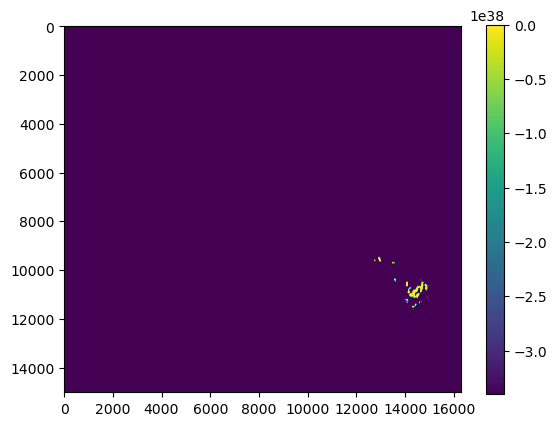

In [68]:
plt.figure()
plt.imshow(a[9,:,:])
plt.colorbar()
plt.show()

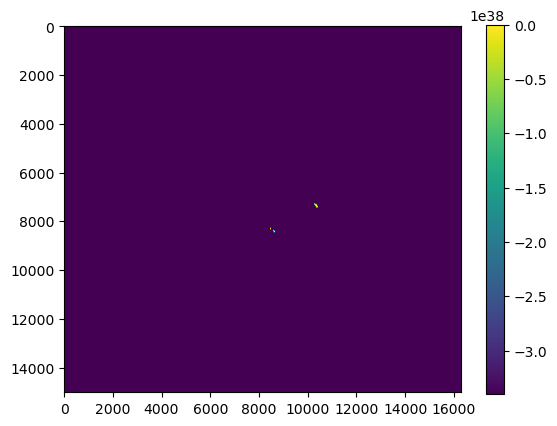

In [69]:
plt.figure()
plt.imshow(a[10,:,:])
plt.colorbar()
plt.show()

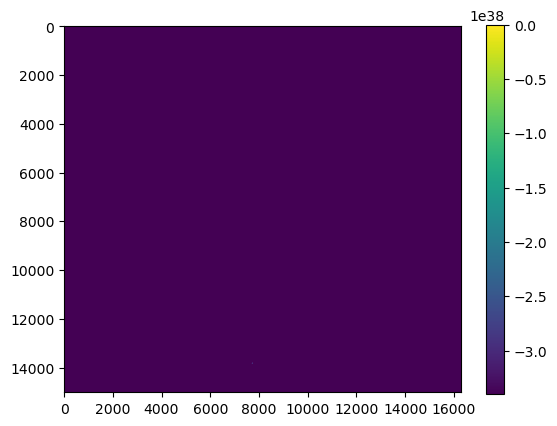

In [70]:
plt.figure()
plt.imshow(a[11,:,:])
plt.colorbar()
plt.show()

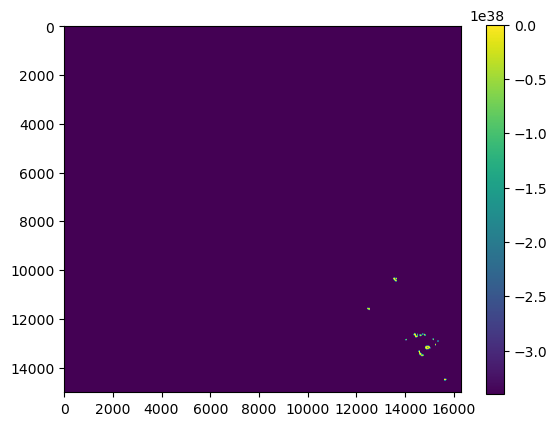

In [71]:
plt.figure()
plt.imshow(a[12,:,:])
plt.colorbar()
plt.show()

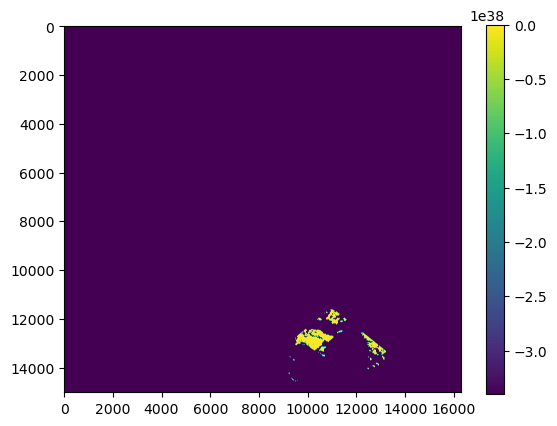

In [72]:
plt.figure()
plt.imshow(a[13,:,:])
plt.colorbar()
plt.show()

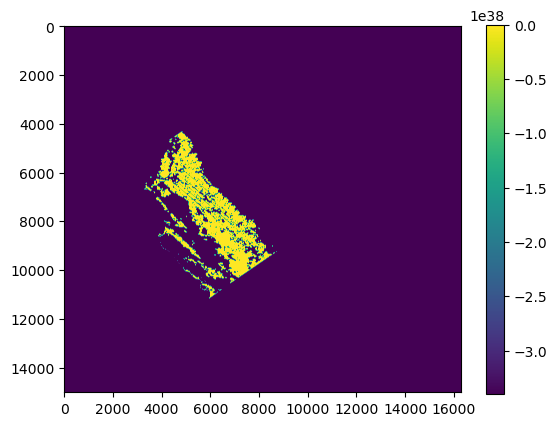

In [73]:
plt.figure()
plt.imshow(a[14,:,:])
plt.colorbar()
plt.show()

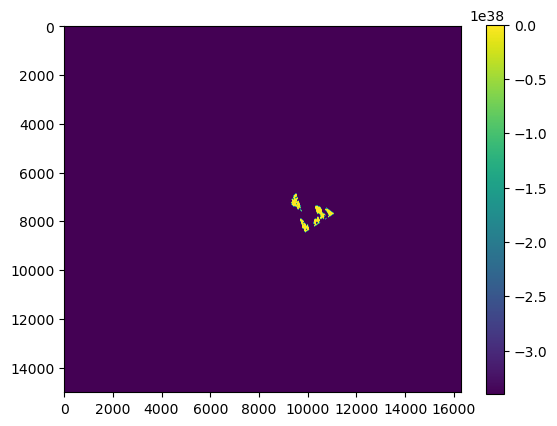

In [74]:
plt.figure()
plt.imshow(a[15,:,:])
plt.colorbar()
plt.show()

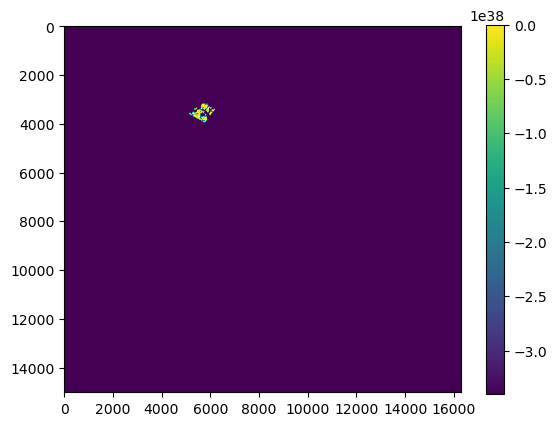

In [75]:
plt.figure()
plt.imshow(a[16,:,:])
plt.colorbar()
plt.show()

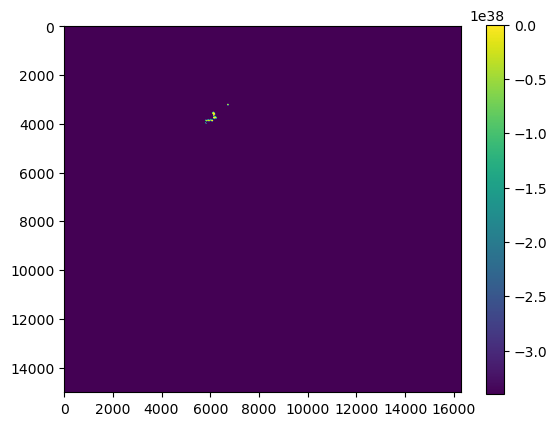

In [76]:
plt.figure()
plt.imshow(a[17,:,:])
plt.colorbar()
plt.show()

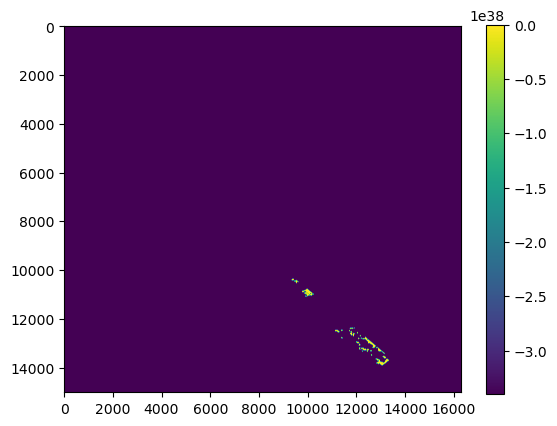

In [77]:
plt.figure()
plt.imshow(a[18,:,:])
plt.colorbar()
plt.show()

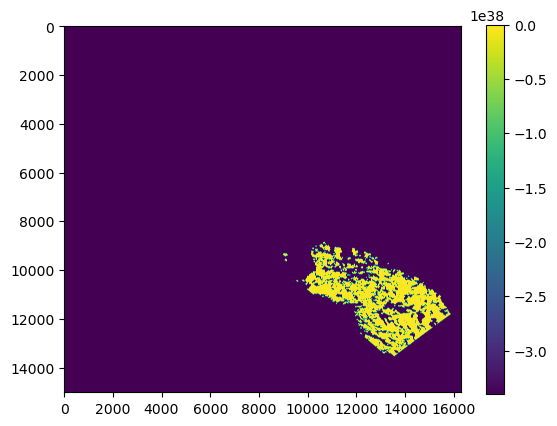

In [78]:
plt.figure()
plt.imshow(a[19,:,:])
plt.colorbar()
plt.show()

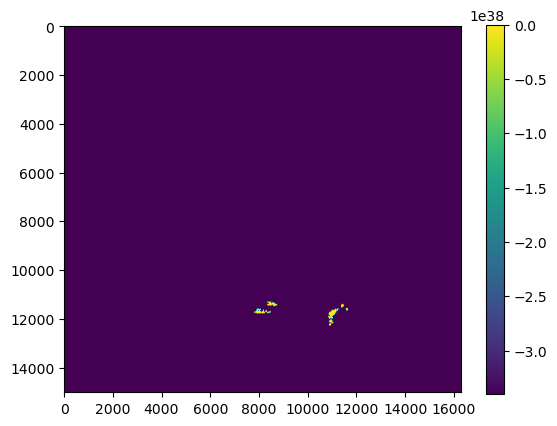

In [79]:
plt.figure()
plt.imshow(a[20,:,:])
plt.colorbar()
plt.show()

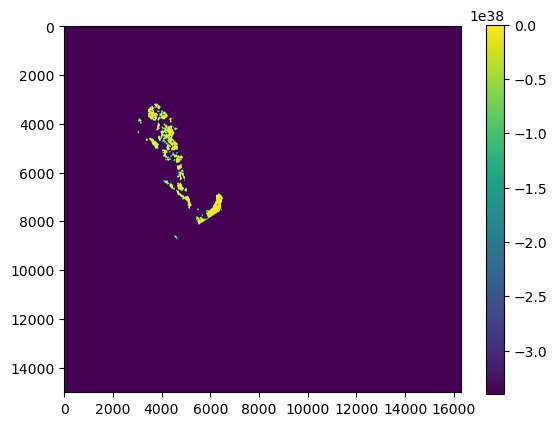

In [80]:
plt.figure()
plt.imshow(a[21,:,:])
plt.colorbar()
plt.show()

<Figure size 640x480 with 0 Axes>

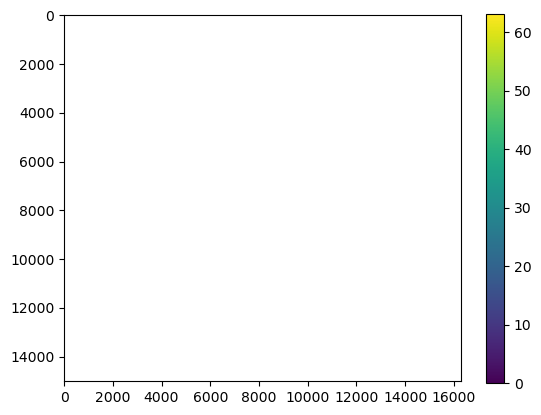

In [11]:
plt.figure()
plt.imshow(a[22,:,:])
plt.colorbar()
plt.show()

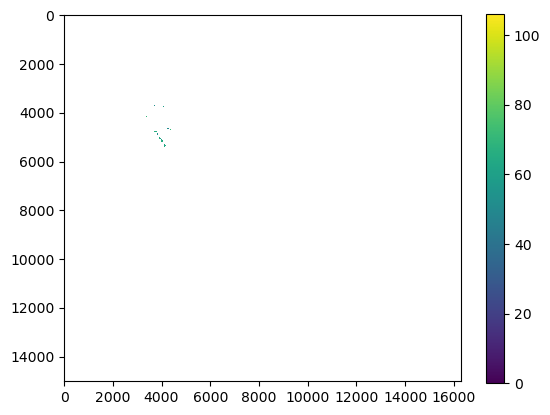

In [12]:
plt.figure()
plt.imshow(a[23,:,:])
plt.colorbar()
plt.show()

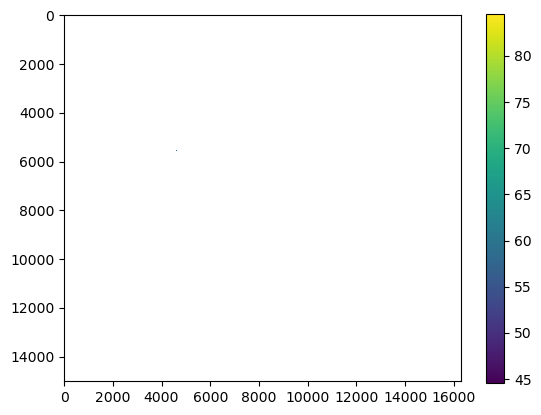

In [13]:
plt.figure()
plt.imshow(a[24,:,:])
plt.colorbar()
plt.show()

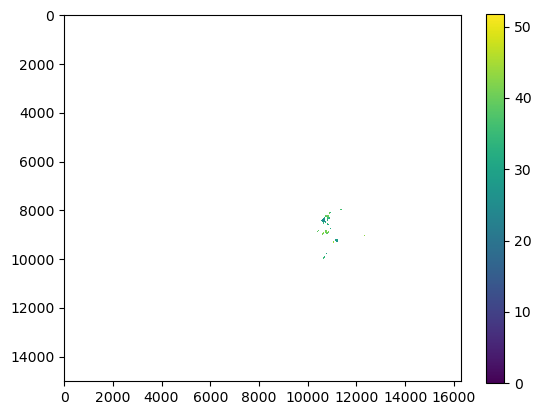

In [14]:
plt.figure()
plt.imshow(a[25,:,:])
plt.colorbar()
plt.show()

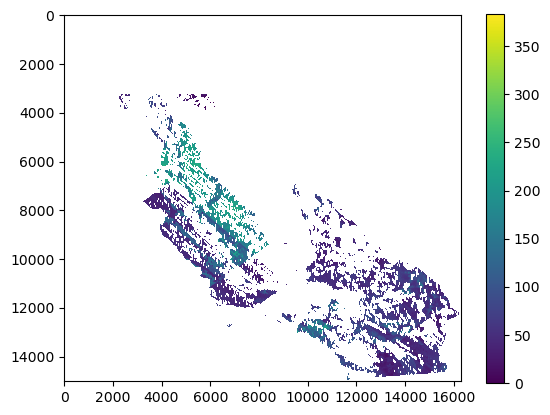

In [25]:
plt.figure()
plt.imshow(means[1])
plt.colorbar()
plt.show()

In [26]:
meanstack = np.stack(means, axis = 0)
print(meanstack.shape)
masked_data = np.ma.masked_array(meanstack, np.isnan(meanstack))
average = np.ma.average(masked_data, axis=0, weights=weights)
result = average.filled(np.nan)
print(result.shape)

(2, 15017, 16289)
(15017, 16289)


In [28]:
weights

[49, 79]

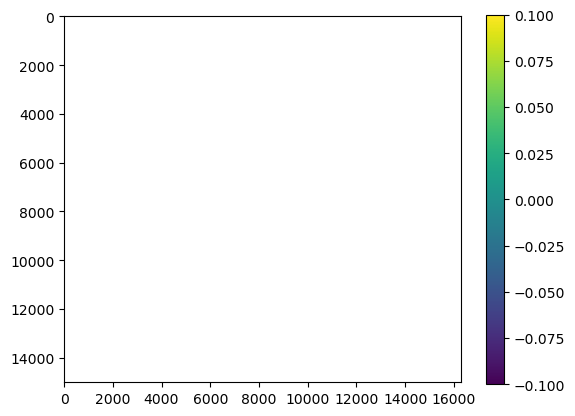

In [27]:
plt.figure()
plt.imshow(result)
plt.colorbar()
plt.show()

In [54]:
    with rasterio.open(str(here("./data/intermediate/ECOSTRESS/ETinst_yeargrouped_{}.tif".format(i))), 'w', **metadata) as dst:
        dst.write(result)

ValueError: Source shape (15017, 16289) is inconsistent with given indexes 1

In [55]:
metadata

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 16289, 'height': 15017, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0006309954707866042, 0.0, -124.409740821737,
       0.0, -0.0006309954708085768, 42.0097687956553), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [8]:
# the indices are a bit more complicated for the fifth (index 4) and eleventh (index 10) timesteps, so let's start with the others
for i in [0,1,2,3,5,6,7,8,9]:
    print("On time interval {}".format(i))
    start_t = time.time()
    
    # figure out which stacks you need 
    start = start_index[i]
    end = end_index[i]
    start_stack = math.floor(start/50) + 1 # plus once since the way I stored it is not zero indexed
    end_stack = math.floor((end-1)/50) + 1 #end-1 since end is non-inclusive
    print("Start_stack {}".format(start_stack))
    print("End_stack {}".format(end_stack))
    
    start = start - 50*(start_stack-1)
    end = end - 50*(start_stack-1)
    print(start)
    print(end)
    
    weights = []
    means = []
    for j in range(start_stack, end_stack+1): # plus one since inclusive
        print("Working on stack {}".format(j))

        # read in the required stacks
        stack = gdal.Open(str(here("./data/intermediate/ECOSTRESS/ETinst_OGunits_{}.tif".format(j))))
        a = stack.ReadAsArray()
        del stack
        a[a < -20] = np.NaN
        print(a.shape)
        
        starter = start
        ender = min(end, a.shape[0]) # plus one to make it non-inclusive
        print(starter)
        print(ender)
        
        weights = weights + [ender - starter]
        print(weights)
        
        means = means + [np.nanmean(a[starter:ender], axis = 0)] # remember ender is not included
        print("successfully took mean of current stack")
        
        start = 0
        end = end - 50
        del a
        
    meanstack = np.stack(means, axis = 0)
    print(meanstack.shape)
    masked_data = np.ma.masked_array(meanstack, np.isnan(meanstack))
    average = np.ma.average(masked_data, axis=0, weights=weights)
    result = average.filled(np.nan)
    print(result.shape)
    
    # write your new raster
    result = np.expand_dims(result, axis=0)
    with rasterio.open(str(here("./data/intermediate/ECOSTRESS/ETinst_yeargrouped_{}.tif".format(i))), 'w', **metadata) as dst:
        dst.write(result)
    
    end_t = time.time()
    print(end_t - start_t)

(100, 15017, 16289)

In [58]:
    result = np.expand_dims(result, axis=0)
    with rasterio.open(str(here("./data/intermediate/ECOSTRESS/ETinst_yeargrouped_{}.tif".format(i))), 'w', **metadata) as dst:
        dst.write(result)

In [9]:
array[array < -20] = np.NaN # NaN values are a very large negative number. I leave room for some negative values in case of condensation
array.shape

(100, 15017, 16289)

In [10]:
# np.unique(array)

In [11]:
# get dates
date_list = pd.read_csv(here("./data/intermediate/ECOSTRESS/dates.csv"))['x'].tolist()

In [12]:
# pd.to_datetime(date_list).to_list()
# date_list[1]

In [13]:
date_list = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in date_list]

In [14]:
# date_list[1]
date_list = date_list[0:50] + date_list[250:300]

In [15]:
# I need to do that thing where I take the first 14 days of the year and put it at the end of the year 
imgs_2019 = array[[d.year==2019 for d in date_list]]
imgs_2020 = array[[d.year==2020 for d in date_list]]

date_array = np.array(date_list)
dates_2019 = date_array[[d.year==2019 for d in date_list]]
dates_2020 = date_array[[d.year==2020 for d in date_list]]

In [24]:

d_19_to_20 = dates_2019[[d < datetime.date(day = 15, month = 1, year = 2019) for d in dates_2019]]
d_19_to_20 = np.array([d.replace(year = 2020) for d in d_19_to_20])
d_20_to_21 = dates_2020[[d < datetime.date(day = 15, month = 1, year = 2020) for d in dates_2020]]
d_20_to_21 = np.array([d.replace(year = 2021) for d in d_20_to_21])

SyntaxError: invalid syntax (<ipython-input-24-91a2e9f6248d>, line 3)

In [ ]:
imgs_2019 = np.concatenate([imgs_2019[[d >= datetime.date(day = 15, month = 1, year = 2019) for d in dates_2019]], imgs_2019[[d < datetime.date(day = 15, month = 1, year = 2019) for d in dates_2019]]])
imgs_2020 = np.concatenate([imgs_2020[[d >= datetime.date(day = 15, month = 1, year = 2020) for d in dates_2020]], imgs_2020[[d < datetime.date(day = 15, month = 1, year = 2020) for d in dates_2020]]])

dates_2019 = np.concatenate([dates_2019[[d >= datetime.date(day = 15, month = 1, year = 2019) for d in dates_2019]], d_19_to_20])
dates_2020 = np.concatenate([dates_2020[[d >= datetime.date(day = 15, month = 1, year = 2020) for d in dates_2020]], d_20_to_21])


In [ ]:
array = np.concatenate([imgs_2019, imgs_2020])

date_list = np.concatenate([dates_2019, dates_2020])

In [14]:
# average by time interval

# these are the start dates of the wanted time intervals
date_starts = [datetime.date(day = 15, month = m, year = y) for y in range(2019,2021) for m in [1,3,5,7,9,11]]
del date_starts[1]

# index of image on or nearest after start date
start_index = [date_list.index(min([i for i in date_list if i >= date_start], key=lambda x:x-date_start)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

# index of image on or nearest previous to start date + 61 days (this is for a non-inclusive index range so this date will be the first one not to be included in a subset)
end_index = [date_list.index(min([i for i in date_list if i <= date_start + datetime.timedelta(days=61)], key=lambda x:date_start+datetime.timedelta(days=61)-x)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

#average by time interval
newarray = np.stack([array[start_index[i]:end_index[i]].mean(axis = 0) for i in range(0,len(start_index))], axis=0)
newarray.shape

['2019-01-27',
 '2019-01-28',
 '2019-01-28',
 '2019-01-29',
 '2019-01-29',
 '2019-01-29',
 '2019-02-01',
 '2019-02-02',
 '2019-05-30',
 '2019-05-31']

In [ ]:
# save 

# get metadata
metadata = img.profile
metadata['count'] = 41 # 41 different time intervals

# write your new raster
with rasterio.open(here("./data/intermediate/ECOSTRESS/ETinst_rolling_average.tif"), 'w', **metadata) as dst:
    dst.write(newarray)